In [1]:
## Imports

from __future__ import print_function, division

import copy
import time
from datetime import datetime
from typing import Type, Any, Callable, Union, List, Optional

import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
from rational.torch import Rational
from sklearn.metrics import precision_score, multilabel_confusion_matrix
from tensorflow.python import layers
from torch import Tensor, optim
from torch.hub import load_state_dict_from_url
from torch.optim import lr_scheduler
from torchvision import transforms
# from rtpt import RTPT
import argparse
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator



Based on RESNET by PyTorch (https://pytorch.org/hub/pytorch_vision_resnet/,
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)




In [2]:
### import different ResNet Models

__all__ = ['ResNet', 'resnet18']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}

In [3]:
### Convolution 3x3

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

In [4]:
### Convolution 1x1

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [5]:
## ResNet's Basic Block

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        if torch.cuda.is_available():
            self.rational = Rational().cuda()
        else:
            self.rational = Rational()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.rational(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.rational(out)

        return out

In [6]:
## ResNet Class

class ResNet(nn.Module):

    def __init__(
            self,
            block: Type[Union[BasicBlock]],
            layers: List[int],
            num_classes: int = 1000,
            zero_init_residual: bool = False,
            groups: int = 1,
            width_per_group: int = 64,
            replace_stride_with_dilation: Optional[List[bool]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        #rational as activation function instead of relu
        if torch.cuda.is_available():
            self.rational = Rational().cuda()
        else:
            self.rational = Rational().cpu()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rational(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [7]:
### ResNet Definition

def _resnet(
        arch: str,
        block: Type[Union[BasicBlock]],
        layers: List[int],
        pretrained: bool,
        progress: bool,
        **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [8]:
### ResNet18 definition
def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [9]:
### prepare data and set training

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=16, drop_last=True)

testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=8, drop_last=True)

classes = trainset.labels

RRN = resnet18(pretrained=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RRN.parameters(), lr=0.001, momentum=0.9)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [10]:
### train model

def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since_epoch = time.time()

        model.train()

        running_loss = 0.0
        running_corrects = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            loss = loss.to(device)
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / trainset.__len__()
        epoch_acc = running_corrects.double() / trainset.__len__()
        scheduler.step()

        time_elapsed_epoch = time.time() - since_epoch

        print('Training: Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(epoch_loss, epoch_acc,
                                                                             time_elapsed_epoch // 60,
                                                                             time_elapsed_epoch % 60))

        # deep copy the model
        # best_model_wts = copy.deepcopy(model.state_dict())

        print()

        precision = torch.tensor(precision_score(labels.to('cpu'), preds.to('cpu'),
                                                 labels=torch.tensor(classes).to('cpu'),
                                                 average='weighted', zero_division=0)).cpu()
        print('precision: {:.4f}'.format(precision))
        cm = torch.tensor(multilabel_confusion_matrix(labels.to('cpu'), preds.to('cpu'),
                                                      labels=torch.tensor(classes).to('cpu')))
        print('confusion matrix: ', cm)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model


In [11]:
### 2nd testing method

def test_model_2(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [12]:
### test

def test_model(model):
    best_acc = 0.0
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / testset.__len__()
    epoch_acc = running_corrects.double() / testset.__len__()

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc

    print()

    precision = torch.tensor(precision_score(labels.to('cpu'), preds.to('cpu'),
                                             labels=torch.tensor(classes).to('cpu'),
                                             average='weighted', zero_division=0)).cpu()
    print('precision: '.format(precision))
    cm = torch.tensor(multilabel_confusion_matrix(labels.to('cpu'), preds.to('cpu'),
                                                  labels=torch.tensor(classes).to('cpu')))
    print('confusion matrix: ', cm)

    print('Best val Acc: {:4f}'.format(best_acc))


In [ ]:
### training + optimization
model_ft = resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features

class_names = trainset.labels
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

torch.save(model_ft, './model.pth')


Epoch 0/1
----------


In [13]:
### show layer
def layer01():
    model_ft = torch.load('./models/model9.pth', map_location=torch.device('cpu')).to('cpu')
    rational_1 = model_ft.layer1.__getitem__(0).rational.cpu()
    rational_1.show()
    plot = rational_1.show(display=False)
    plot.legend('layer 1 Rational Function 0')
    plot.savefig('plot.svg')
    print('layer 1 Rational Function', 0, ' ', rational_1)
    rational_2 = model_ft.layer1.__getitem__(1).rational.cpu()
    rational_2.show()
    print('layer 1 Rational Function', 1, ' ', rational_2)

In [14]:
def layer_plot(): 
    model_ft = torch.load('./models/model9.pth', map_location=torch.device('cpu')).to('cpu')
    rational_0 = model_ft.rational.cpu()
    rational_1 = model_ft.layer1.__getitem__(0).rational.cpu()
    rational_2 = model_ft.layer1.__getitem__(1).rational.cpu()
    rational_3 = model_ft.layer2.__getitem__(0).rational.cpu()
    rational_4 = model_ft.layer2.__getitem__(1).rational.cpu()
    rational_5 = model_ft.layer3.__getitem__(0).rational.cpu()
    rational_6 = model_ft.layer3.__getitem__(1).rational.cpu()
    rational_7 = model_ft.layer4.__getitem__(0).rational.cpu()
    rational_8 = model_ft.layer4.__getitem__(1).rational.cpu()
    plot = rational_0.show(display=False)
    plot = rational_1.show(display=False)
    plot = rational_2.show(display=False)
    plot = rational_3.show(display=False)
    plot = rational_4.show(display=False)
    plot = rational_5.show(display=False)
    plot = rational_6.show(display=False)
    plot = rational_7.show(display=False)
    plot = rational_8.show(display=False)
    plot.legend(['Layer 0 Rational Function','Layer 1 Rational Function 0', 'Layer 1 Rational Function 1', 'Layer 2 Rational Function 0',
                 'Layer 2 Rational Function 1', 'Layer 3 Rational Function 0', 'Layer 3 Rational Function 1',
                 'Layer 4 Rational Function 0', 'Layer 4 Rational Function 1'])
    plot.savefig('resnet_plots_3.svg')

In [15]:
layer_plot()

AttributeError: Can't get attribute 'RationalResNet' on <module '__main__'>

In [22]:
layer01()

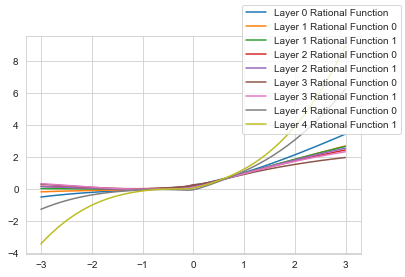

In [23]:
layer_plot()

In [16]:
layer01()

AttributeError: Can't get attribute 'RationalResNet' on <module '__main__'>

In [17]:
### show layer
def layer02():
    model_ft = torch.load('./models/model2.pth', map_location=torch.device('cpu')).to('cpu')
    rational_1 = model_ft.layer2.__getitem__(0).rational.cpu()
    rational_1.show()
    print('layer 3 Rational Function', 0, ' ', rational_1)
    rational_2 = model_ft.layer2.__getitem__(1).rational.cpu()
    rational_2.show()
    print('layer 2 Rational Function', 1, ' ', rational_2)

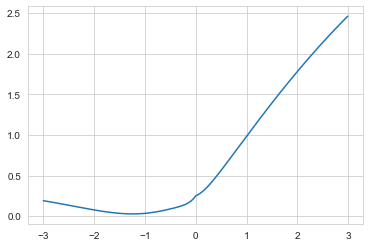

layer 3 Rational Function 0   Rational Activation Function (PYTORCH version A) of degrees (5, 4) running on cpu


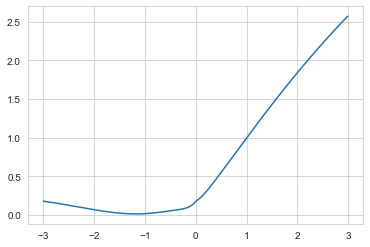

layer 2 Rational Function 1   Rational Activation Function (PYTORCH version A) of degrees (5, 4) running on cpu


In [18]:
layer02()

In [16]:
### show layer
def layer03():
    model_ft = torch.load('./model2.pth', map_location=torch.device('cpu')).to('cpu')
    rational_1 = model_ft.layer3.__getitem__(0).rational.cpu()
    rational_1.show()
    print('layer 3 Rational Function', 0, ' ', rational_1)
    rational_2 = model_ft.layer3.__getitem__(1).rational.cpu()
    rational_2.show()
    print('layer 3 Rational Function', 1, ' ', rational_2)

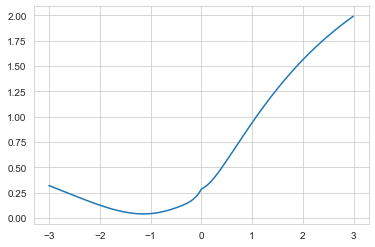

layer 3 Rational Function 0   Rational Activation Function (PYTORCH version A) of degrees (5, 4) running on cpu


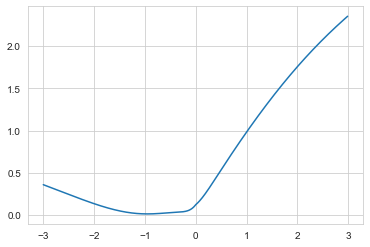

layer 3 Rational Function 1   Rational Activation Function (PYTORCH version A) of degrees (5, 4) running on cpu


In [17]:
layer03()

In [18]:
### show layer
def layer04():
    model_ft = torch.load('./model2.pth', map_location=torch.device('cpu')).to('cpu')
    rational_1 = model_ft.layer4.__getitem__(0).rational.cpu()
    rational_1.show()
    print('layer 4 Rational Function', 0, ' ', rational_1)
    rational_2 = model_ft.layer4.__getitem__(1).rational.cpu()
    rational_2.show()
    print('layer 4 Rational Function', 1, ' ', rational_2)

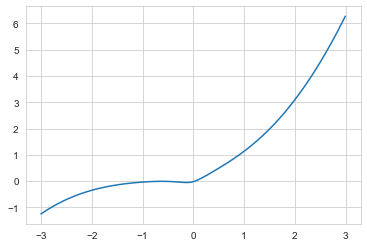

layer 4 Rational Function 0   Rational Activation Function (PYTORCH version A) of degrees (5, 4) running on cpu


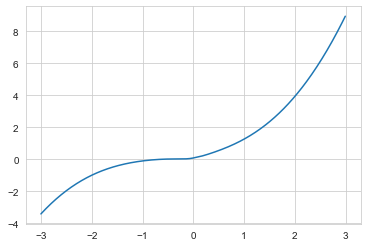

layer 4 Rational Function 1   Rational Activation Function (PYTORCH version A) of degrees (5, 4) running on cpu


In [19]:
layer04()

In [44]:
model_ft = torch.load('./model.pth', map_location=torch.device('cpu')).to('cpu')
model_ft = model_ft.eval()
test_model(model_ft)


NameError: name 'forward_A_5_4' is not defined

In [43]:
test_model_2(model_ft)



NameError: name 'forward_A_5_4' is not defined